In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import orbipy as op

In [2]:
#создание модели
model = op.crtbp3_model('Earth-Moon (default)')
plotter = op.plotter.from_model(model, length_units='Mm')
scaler = op.scaler.from_model(model)

In [3]:
#отсечение корня
def findstep1(f, x0, data, n=1, k=0.01):
    dx = k * abs(x0)
    x1 = x0 + dx
    f0 = f(x0, n, data)
    f1 = f(x1, n, data)
    
    if abs(f1[3]) > abs(f0[3]) and f1[3] * f0[3] > 0:
        dx = -dx
        x0, x1 = x1, x0
        f0, f1 = f1, f0
    while f0[3] * f1[3] > 0:
        x0, x1 = x1, x1 + dx
        f0 = f(x0, n, data)
        f1 = f(x1, n, data)
    return min(x0, x1), max(x0, x1)

#метод секущих
def sec_method1(f, x0, x_end, data, eps=1e-6, n=1):
    diff = 1
    it = 0
    fx0 = f(x0, n, data)
    fx_end = f(x_end, n, data)
    while diff >= eps and it < 1500:
        x1 = x0 - (x_end - x0) * fx0[3] / (fx_end[3] - fx0[3])
        diff = abs(x0 - x1)
        x0 = x1
        fx0 = f(x0, n, data)
        it+=1
    return x0

In [4]:
def f1v(vy, n, data):
    det_y1 = op.event_detector(model, events=[op.eventY(count=n)])
    s = model.get_zero_state()
    s[0], s[2], s[4] = data[0], data[2], vy
    arr0, ev = det_y1.prop(s, 1, 20 * np.pi, ret_df=False, last_state='last')
    if ev.shape[0]==0:
        return arr0[-1, 1:]
    return ev[-1, 4:10]

In [52]:
def optv(f, v0, data):
    k = 0.01
    vbeg, vend = findstep1(f, v0, data, n=1, k=k)
    v1 = sec_method1(f, vbeg, vend, data, eps=1e-6, n=1)
    v0 = v1
    for i in range(1, 4):
        k *= 0.05
        vbeg, vend = findstep1(f, v0, data, n=i+1, k=k)
        v1 = sec_method1(f, vbeg, vend, data, eps=1e-6, n=i+1)
        v0 = v1       
    return v0

In [6]:
def optv2(f, v0, data):
    #print('find v')
    #print(0)
    #print(data)
    
    k = 0.01    
    vbeg, vend = findstep1(f, v0, data, n=1, k=k)
    v1 = sec_method1(f, vbeg, vend, data, eps=1e-6, n=1)
    v0 = v1
    
    for i in range(1, 4):
        #print(i)
        k *= 0.1
        #print('findstep, v0=', v0)
        vbeg, vend = findstep1(f, v0, data, n=i+1, k=k)
        #print('sec_method')
        v1 = sec_method1(f, vbeg, vend, data, eps=1e-6, n=i+1)
        v0 = v1
    #print(v0)
    
    fig, ax = plt.subplots(1, 1, figsize = (5,5))
    det_y1 = op.event_detector(model, events=[op.eventY(count=4)])
    s = model.get_zero_state()
    s[0], s[2], s[4] = data[0], data[2], v0
    arr0, ev = det_y1.prop(s, 1, 20 * np.pi, ret_df=False, last_state='last')
    ax.plot(arr0[:, 1]*model.R, arr0[:, 2]*model.R)
    
    return v0

In [7]:
def NextDxNewton(dx, y0, y1, dxmax, tol):
    NewDx = 0
    if abs(y1)>=tol and y0 != y1:
        NewDx = dx
        if y1 != 0:  
            NewDx = max(min(dx * y1/(y0-y1),dxmax),-dxmax)

    return NewDx

class optimizer:
    dx = 0.001
    dxmax = 0.1
    xvals = []
    yvals = []
    step = 0
    tolerance = 0.000001

    def __init__(self):
        self.xvals = []
        self.yvals = []
        self.step = 0
        
    def needNextStep(self):
        if len(self.yvals) <= 2: return True
        if abs(self.xvals[0]-self.xvals[1]) <= self.tolerance:
            return False
        else:
            return True
            
            
    def nextX(self, x, y):
        self.step+=1;
        
        i = 0
        #находим место для добавления точки, чтобы массив остался отсортированным
        while i < min(2, len(self.yvals)) and y > self.yvals[i]: i+=1
        self.xvals.insert(i,x)
        self.yvals.insert(i,y)

        xvals = self.xvals
        yvals = self.yvals
        
        if self.step == 1:
            return x+self.dx

        x1 = xvals[0]+NextDxNewton(xvals[1]-xvals[0], yvals[0], yvals[1], self.dx, 0)
        if self.step > 2:
            #print(xvals, yvals)
            a = yvals[0]/(xvals[0]-xvals[1])/(xvals[0]-xvals[2]) - yvals[1]/(xvals[0]-xvals[1])/(xvals[1]-xvals[2]) + yvals[2]/(xvals[1]-xvals[2])/(xvals[0]-xvals[2])
            #print(a)
            if a > 0:
                b = (yvals[0]-yvals[1])/(xvals[0]-xvals[1]) - a*(xvals[0]+xvals[1])
                xm = -b/2/a
                x1 = x + max(min(xm-x, self.dxmax), -self.dxmax)
        
        return x1

    def getXY(self):
        return (self.xvals[0], self.yvals[0])


# Поиск гало орбиты

In [27]:
def nextpoint(p):
    X0km = p[0]
    Z0km = p[1] - radius
    v0 = p[2]
        
    y0 = model.get_zero_state()
    y0[0], y0[2], y0[4] = [X0km / model.R, Z0km / model.R, v0]
        
    v0 = optv2(f1v, y0[4], y0)
            
    y0[4] = v0
    det_y0 = op.event_detector(model, events=[op.eventY(count=2)])
    arr, evouty = det_y0.prop(y0, 0, 20 * np.pi, ret_df=False, last_state='last')
    
    d22 = np.linalg.norm(evouty[-1, 4:10] - y0)
    p[0], p[1], p[2] = X0km, Z0km, v0
    
    return d22

In [28]:
X0km, Z0km, v0 = 350000, 33748, -0.29
radius = 100

x0vals = []
z0vals = []
d22vals = []

y0 [ 0.91050989  0.          0.08779396  0.         -0.29        0.        ]
y1 [ 0.91050989  0.          0.08753382  0.         -0.29647161  0.        ]
v0 -0.2964716077211869
0 350000.0 33648.0 0.04100718708450247

y0 [ 0.91050989  0.          0.08753382  0.         -0.29647161  0.        ]
y1 [ 0.91050989  0.          0.08727367  0.         -0.29714987  0.        ]
v0 -0.29714986900879803
1 350000.0 33548.0 0.039616537992293185

y0 [ 0.91050989  0.          0.08727367  0.         -0.29714987  0.        ]
y1 [ 0.91050989  0.          0.08701353  0.         -0.29782852  0.        ]
v0 -0.29782852399683385
2 350000.0 33448.0 0.03822385485881402

y0 [ 0.91050989  0.          0.08701353  0.         -0.29782852  0.        ]
y1 [ 0.91050989  0.          0.08675338  0.         -0.29850757  0.        ]
v0 -0.29850756764207953
3 350000.0 33348.0 0.03682914143467647

y0 [ 0.91050989  0.          0.08675338  0.         -0.29850757  0.        ]
y1 [ 0.91050989  0.          0.08649324  0.        

C:\Users\gafda\AppData\Local\Temp/ipykernel_13992/160481101.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, figsize = (5,5))


y1 [ 0.91050989  0.          0.08259105  0.         -0.30942075  0.        ]
v0 -0.3094207476285041
19 350000.0 31748.0 0.014245430108776881

y0 [ 0.91050989  0.          0.08259105  0.         -0.30942075  0.        ]
y1 [ 0.91050989  0.          0.08233091  0.         -0.31010556  0.        ]
v0 -0.3101055580332102
20 350000.0 31648.0 0.012818501191345796

y0 [ 0.91050989  0.          0.08233091  0.         -0.31010556  0.        ]
y1 [ 0.91050989  0.          0.08207076  0.         -0.31079065  0.        ]
v0 -0.31079065447886584
21 350000.0 31548.0 0.011389836126506089

y0 [ 0.91050989  0.          0.08207076  0.         -0.31079065  0.        ]
y1 [ 0.91050989  0.          0.08181061  0.         -0.31147603  0.        ]
v0 -0.3114760307265824
22 350000.0 31448.0 0.009959437301559274

y0 [ 0.91050989  0.          0.08181061  0.         -0.31147603  0.        ]
y1 [ 0.91050989  0.          0.08155047  0.         -0.31216168  0.        ]
v0 -0.3121616804786575
23 350000.0 31348.0 0.0

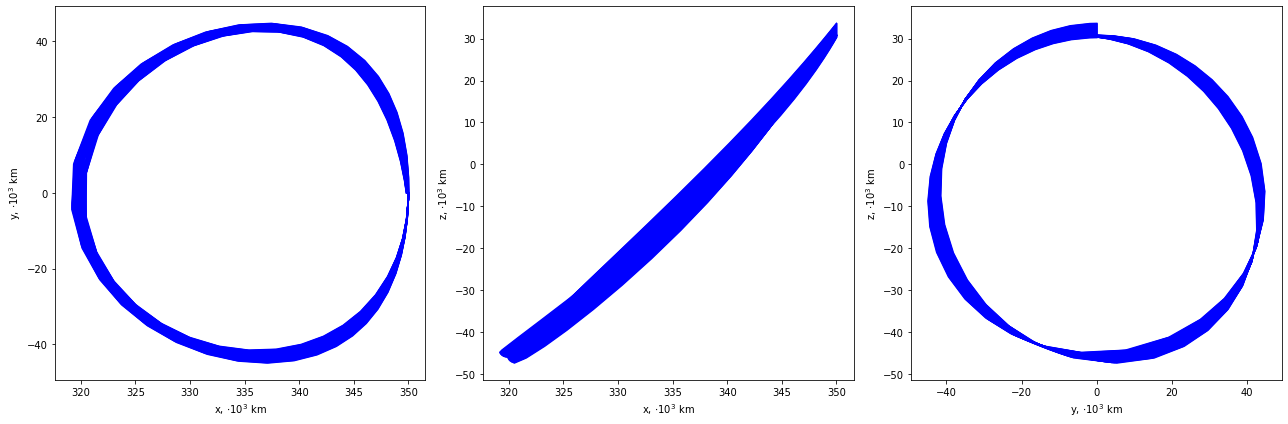

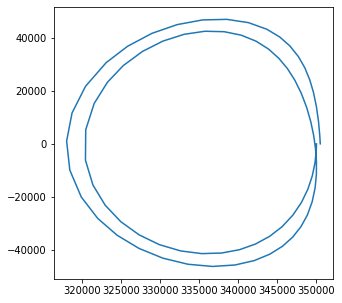

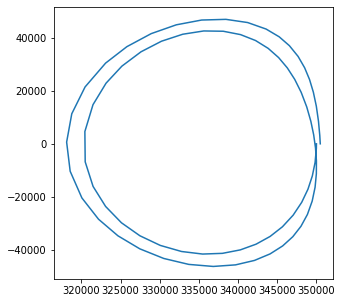

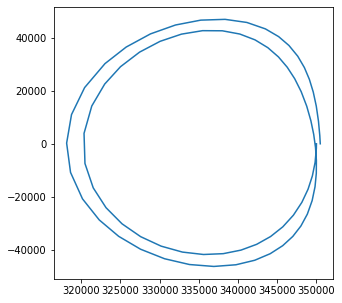

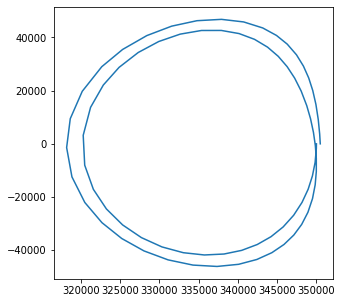

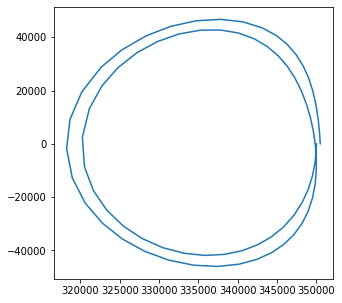

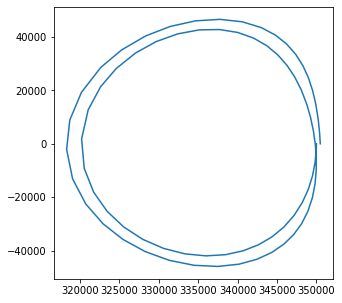

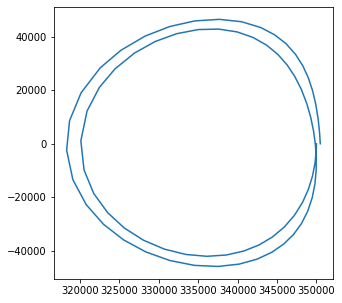

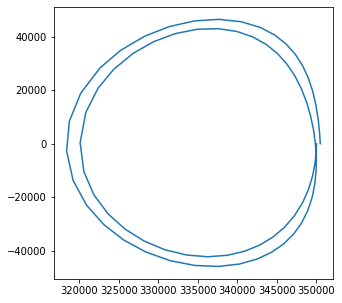

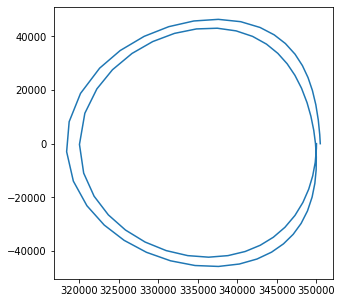

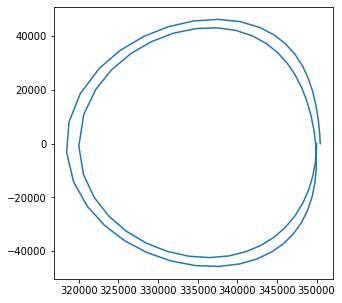

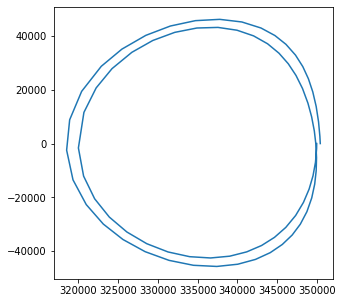

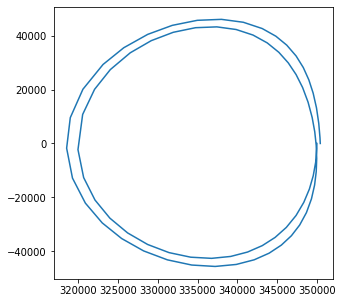

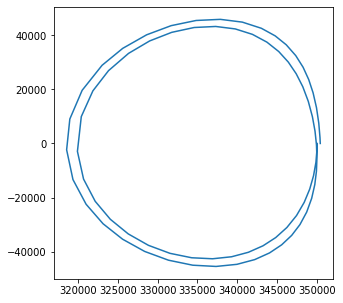

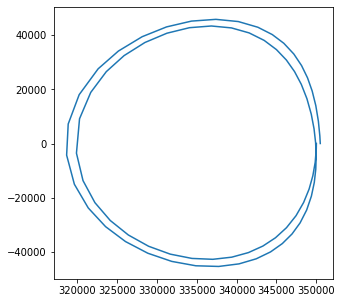

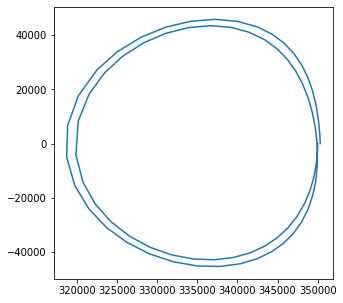

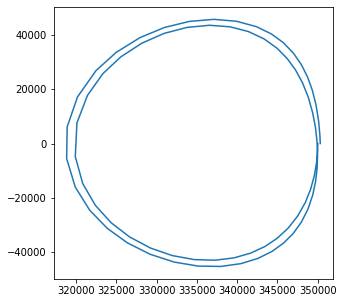

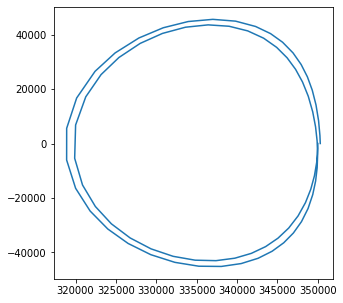

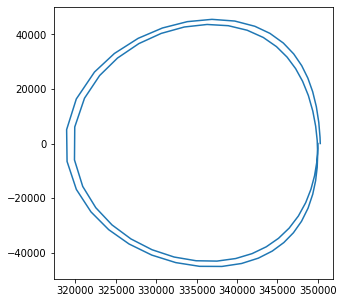

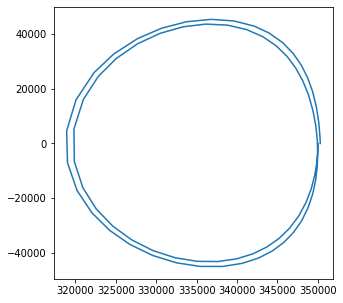

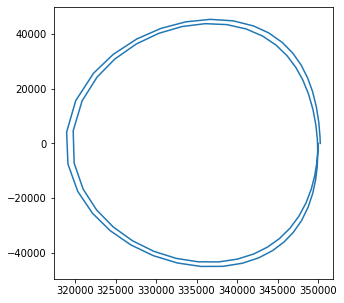

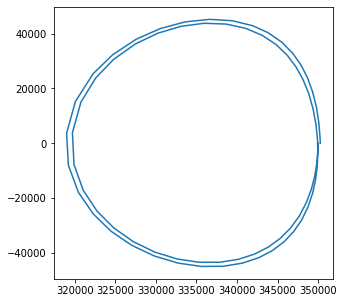

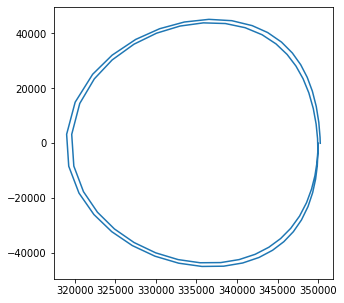

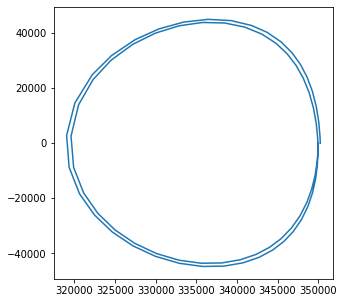

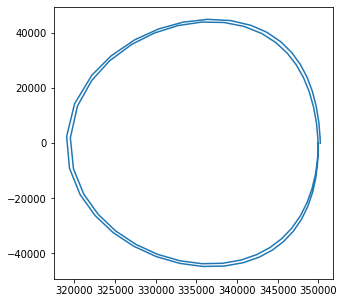

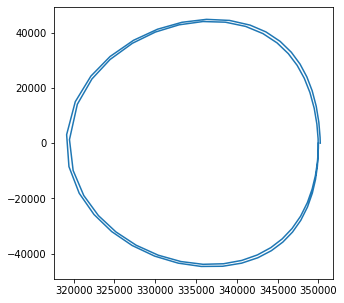

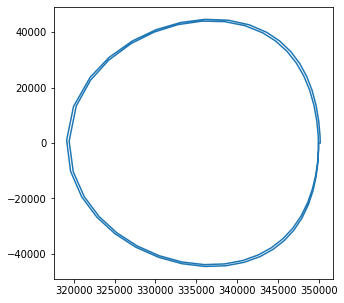

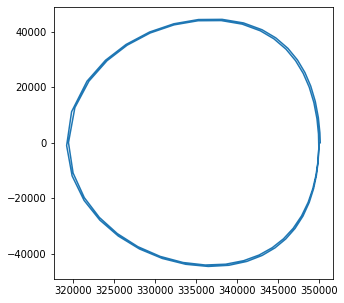

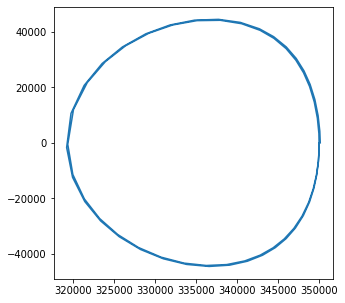

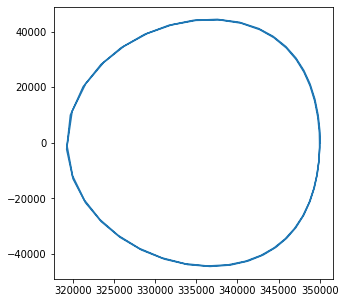

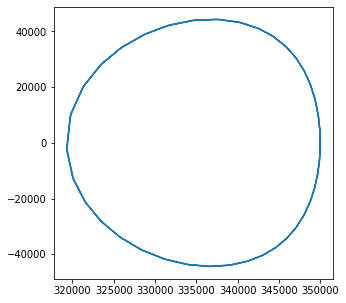

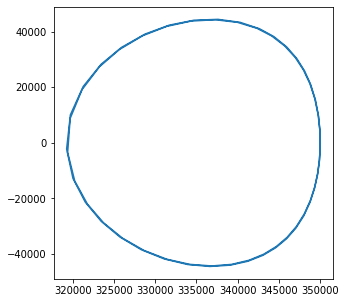

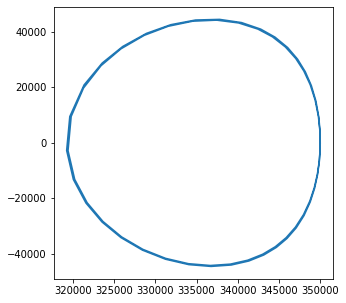

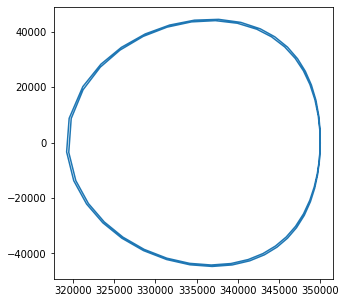

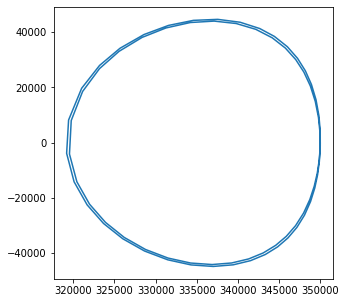

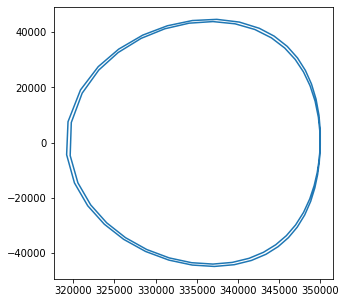

In [29]:
fig1, ax = plt.subplots(1, 3, figsize = (18,6))

for n in range(0, 35):
    y0 = model.get_zero_state()
    y0[0], y0[2], y0[4] = [X0km / model.R, Z0km / model.R, v0]
    print('y0', y0)
    
    p = np.array([X0km, Z0km, v0])
    
    d22 = nextpoint(p)
    
    X0km, Z0km, v0 = p[0], p[1], p[2]    
    y0[0], y0[2], y0[4] = [X0km / model.R, Z0km / model.R, v0]
    det_y0 = op.event_detector(model, events=[op.eventY(count=2)])
    arr1, evouty = det_y0.prop(y0, 0, 20 * np.pi, ret_df=False, last_state='last')
    
    print('y1', y0)
    print('v0', v0)
    print(n, X0km, Z0km, d22)
    print()
    
    x0vals.append(X0km)
    z0vals.append(Z0km)
    d22vals.append(d22)

    plotter.plot_proj(arr1, ax=ax)

(0.0, 0.1)

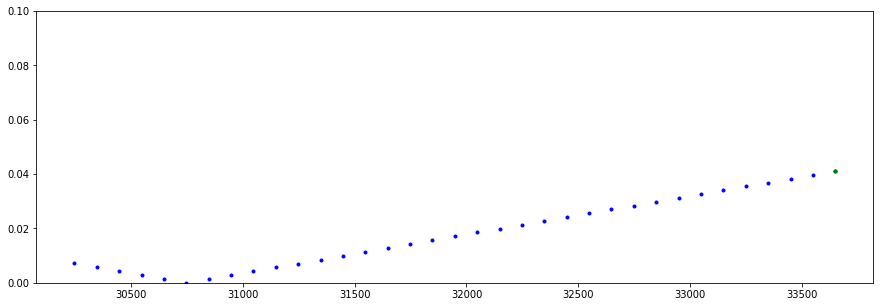

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (15,5))
ax.plot(z0vals, d22vals, '.b')
ax.plot(z0vals[0], d22vals[0], '.g')
ax.set_ylim([0, 0.1])

# Расчет семейства орбит

In [69]:
X0km = 0.91050989 * model.R
Z0km =  0.07998959 * model.R
v0 = -0.31628096
radius = 25
alpha0 = 0.37
dalpha = np.pi

x0vals = []
z0vals = []
vvals = []
alphavals = []
tvals = []
d22vals = []

y1 [ 0.91080425  0.          0.08012332  0.         -0.31704453  0.        ]

0 350113.1521060152 30799.403398330698 -0.32464380245178026 0.3717614321200854 1.6272695547784718e-26
y1 [ 0.91086486  0.          0.08014689  0.         -0.31721171  0.        ]

1 350136.45175262727 30808.465763791937 -0.32481499870351693 0.37094317458529696 6.2960393217253446e-27
y1 [ 0.91092549  0.          0.08017042  0.         -0.31737894  0.        ]

2 350159.7588096039 30817.509053850736 -0.3249862287785715 0.37012460558536603 1.192919859518651e-26
y1 [ 0.91098614  0.          0.0801939   0.         -0.31754619  0.        ]

3 350183.07326415624 30826.533255141072 -0.32515749269430394 0.3693057231952007 6.479914027776561e-27
y1 [ 0.91104681  0.          0.08021732  0.         -0.31771348  0.        ]

4 350206.3951034557 30835.538354345917 -0.3253287904676841 0.3684865292650785 1.6291037027257996e-26


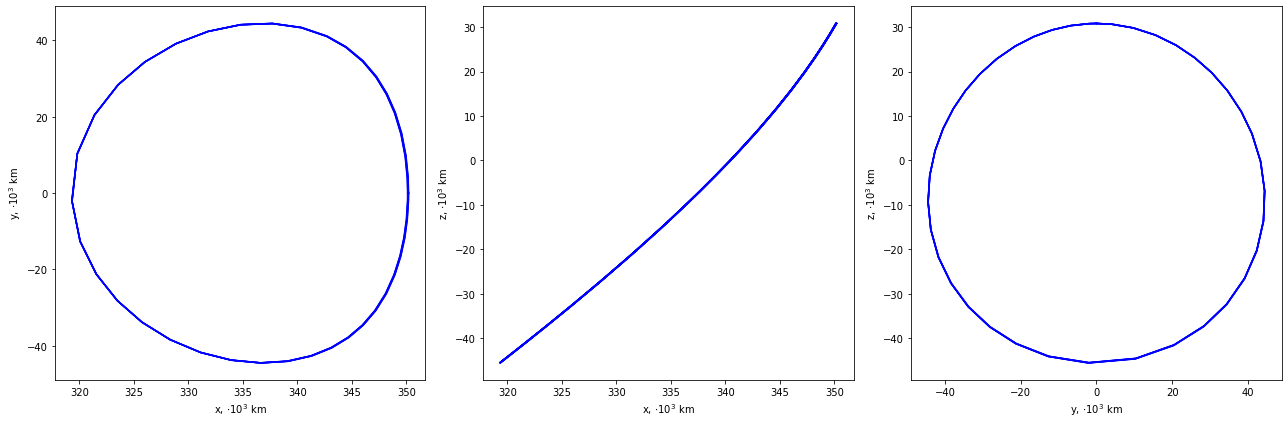

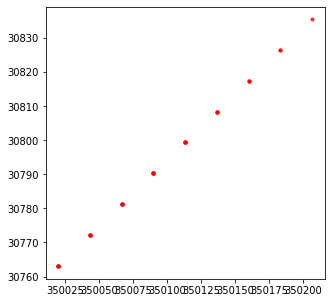

In [72]:
fig1, ax = plt.subplots(1, 3, figsize = (18,6))
fig2, ax2 = plt.subplots(1, 1, figsize = (5,5))

X00km = X0km
Z00km = Z0km

for n in range(0, 5):
    X00km = X0km
    Z00km = Z0km
    v1 = v0
    
    opt0 = optimizer()
    opt0.dx = 1
    opt0.dxmax = np.pi
    opt0.tolerance = 1e-10
    
    distvals = np.array([100, v0])
    
    for k in range(25):
        if opt0.needNextStep() == False: break
    
        X1km = X00km + radius * np.cos(alpha0)
        Z1km = Z00km + radius * np.sin(alpha0)
        
        cur = model.get_zero_state()
        cur[0], cur[2], cur[4] = X1km / model.R, Z1km / model.R, v1
        
        v1 = optv(f1v, cur[4], cur)
        cur[4] = v1

        det_y1 = op.event_detector(model, events=[op.eventY(count=2)])
        arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
        d22 = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])**2
        if d22 < distvals[0]:
            distvals[0] = d22
            distvals[1] = v1
        alpha0 = opt0.nextX(alpha0, d22)
              
    alpha0, d22 = opt0.getXY()
    v0 = distvals[1]
    d22 = distvals[0]
    
    X00km, Z00km = X0km  + radius * np.cos(alpha0), Z0km + radius * np.sin(alpha0)
    X0km, Z0km = X00km, Z00km
    
    y0 = model.get_zero_state()    
    y0[0], y0[2], y0[4] = [X0km / model.R, Z0km/ model.R, v0]
    print('y1', y0)
    
    det_y0 = op.event_detector(model, events=[op.eventY(count=2)])
    arr, evout = det_y0.prop(y0, 0, 20 * np.pi, ret_df=False, last_state='last')

    print()
    print(n, X0km, Z0km, scaler(v0, 'nd/nd-km/s'), alpha0, d22)
    
    x0vals.append(X0km)
    z0vals.append(Z0km)
    vvals.append(scaler(v0, 'nd/nd-km/s'))
    alphavals.append(alpha0)
    tvals.append(evout[-1, 3] / np.pi)
    d22vals.append(d22) 
    
    arr2save = np.vstack((x0vals, z0vals, vvals, alphavals, d22vals, tvals)).T
    plotter.plot_proj(arr, ax=ax)
    
    ax2.plot(x0vals, z0vals,'.r', alpha=0.8, linewidth=2)
    np.savetxt('halo r' + str(radius) + ' dalpha' +  str(dalpha) + 'smc.txt', arr2save)

y1 [ 0.9111075  0.         0.0802407  0.        -0.3178808  0.       ]

0 350229.7243146687 30844.524338108382 -0.3255001221162605 0.36766702183272665 1.8005103437403535e-26
y1 [ 0.91116821  0.          0.08026402  0.         -0.31804815  0.        ]

1 350253.0608849402 30853.491193073256 -0.32567148765770343 0.366847200717097 1.4647540113314358e-26
y1 [ 0.91122894  0.          0.0802873   0.         -0.31821554  0.        ]

2 350276.40480139153 30862.438905893567 -0.32584288710974035 0.366027066017058 1.8556739471496398e-26
y1 [ 0.91128969  0.          0.08031053  0.         -0.31838296  0.        ]

3 350299.7560511394 30871.367463179748 -0.32601432049070145 0.36520661565280466 9.17684492252734e-27
y1 [ 0.91135045  0.          0.08033371  0.         -0.31855042  0.        ]

4 350323.1146212577 30880.276851600305 -0.3261857878184324 0.3643858518561822 8.594095006443465e-27


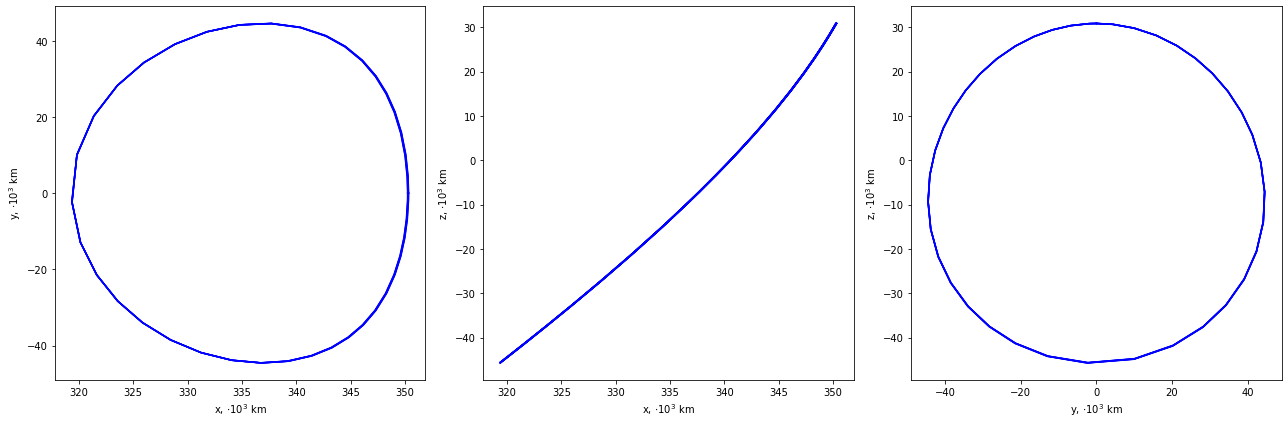

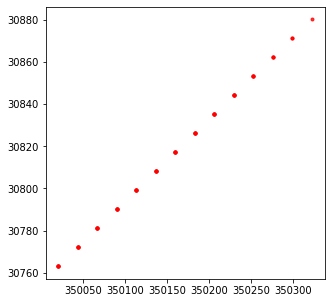

In [73]:
fig1, ax = plt.subplots(1, 3, figsize = (18,6))
fig2, ax2 = plt.subplots(1, 1, figsize = (5,5))

X00km = X0km
Z00km = Z0km

for n in range(0, 5):
    X00km = X0km
    Z00km = Z0km
    v1 = v0
    
    opt0 = optimizer()
    opt0.dx = 0.1
    opt0.dxmax = 0.5
    opt0.tolerance = 1e-10
    
    distvals = np.array([100, v0])
    
    for k in range(25):
        if opt0.needNextStep() == False: break
    
        X1km = X00km + radius * np.cos(alpha0)
        Z1km = Z00km + radius * np.sin(alpha0)
        
        cur = model.get_zero_state()
        cur[0], cur[2], cur[4] = X1km / model.R, Z1km / model.R, v1
        
        v1 = optv(f1v, cur[4], cur)
        cur[4] = v1

        det_y1 = op.event_detector(model, events=[op.eventY(count=2)])
        arr1, ev1 = det_y1.prop(cur, 0., 20.*np.pi, last_state='last')
        d22 = np.linalg.norm(cur[:3] - ev1.iloc[-1, 4:7])**2
        if d22 < distvals[0]:
            distvals[0] = d22
            distvals[1] = v1
        alpha0 = opt0.nextX(alpha0, d22)
              
    alpha0, d22 = opt0.getXY()
    v0 = distvals[1]
    d22 = distvals[0]
    
    X00km, Z00km = X0km  + radius * np.cos(alpha0), Z0km + radius * np.sin(alpha0)
    X0km, Z0km = X00km, Z00km
    
    y0 = model.get_zero_state()    
    y0[0], y0[2], y0[4] = [X0km / model.R, Z0km/ model.R, v0]
    print('y1', y0)
    
    det_y0 = op.event_detector(model, events=[op.eventY(count=2)])
    arr, evout = det_y0.prop(y0, 0, 20 * np.pi, ret_df=False, last_state='last')

    print()
    print(n, X0km, Z0km, scaler(v0, 'nd/nd-km/s'), alpha0, d22)
    
    x0vals.append(X0km)
    z0vals.append(Z0km)
    vvals.append(scaler(v0, 'nd/nd-km/s'))
    alphavals.append(alpha0)
    tvals.append(evout[-1, 3] / np.pi)
    d22vals.append(d22) 
    
    arr2save = np.vstack((x0vals, z0vals, vvals, alphavals, d22vals, tvals)).T
    plotter.plot_proj(arr, ax=ax)
    
    ax2.plot(x0vals, z0vals,'.r', alpha=0.8, linewidth=2)
    np.savetxt('halo r' + str(radius) + ' dalpha' +  str(dalpha) + 'smc.txt', arr2save)